## Project 2: House Hunting for Families in King County

Name:Sam Lim

Course: Data Science Full Time

Date: 3/26/21 4:30 pm EST

Instructor: Claude Fried


In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
import sklearn.metrics as metrics
from random import gauss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from statsmodels.stats import outliers_influence
import sklearn
sns.set_theme(color_codes=True)

## Business Problem

A realtorship is experiencing an influx of smaller families coming into King County as Microsoft has expanded and hired substantial amount of workers. It is your job to find a home for these families, and many also live alone. 

## Data Observation and Cleaning
### Data Keys
id - unique identified for a house <br>
price- Price is prediction target <br>
bedrooms- Number of Bedrooms/House <br>
bathrooms- Number of bathrooms/bedrooms <br>
sqft_living- Square footage of the home <br>
sqft_lot- Square footage of the lot <br>
floors- Total floors (levels) in house <br>
waterfront - House which has a view to a waterfront <br>
condition - How good the condition is ( Overall ) <br>
grade - overall grade given to the housing unit, based on King County grading system <br>
yr_built - Built Year

## Data Prep and Cleaning

First, unnecessary columns are dropped as well as some rows that contained incorrect data across the independent variables. The grade and condition columns are changed to type string so that it is seen as categorical data and not numerical.

In [2]:
kc_data=pd.read_csv('data/kc_house_data.csv')
kc_new=kc_data.drop(columns=['date','view','sqft_above','sqft_basement','yr_renovated','lat','long','sqft_living15','sqft_lot15','waterfront'])
kc_new=kc_new.set_index('id')
kc_new.loc[kc_new['bedrooms']==33]=3 
#seemed to be an error because there were only 1.75 bathrooms and sqft_living was only 1620
kc_new=kc_new.drop(index=2402100895, axis=0)
#3 beds,baths,sqft_living, etc. everything was 3
kc_new['bldg_age']=2021-kc_new['yr_built']
# kc_new['sqft_lot_only']=kc_new['sqft_lot']-(kc_new['sqft_living']/kc_new['floors']) #0 if (kc_new['floors']==1 && kc_new['sqft_living']==kc_new['sqft_lot']) else kc_new['sqft_lot']-(kc_new['sqft_living']/kc_new['floors'])
kc_new['grade']=kc_new['grade'].astype('str')         # grade and condition were type int, so needed to be changed
kc_new['condition']=kc_new['condition'].astype('str') # they are still categorized later
kc_new['zipcode']=kc_new['zipcode'].astype('str')

In [159]:
kc_new.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,bldg_age
id,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,3,7,1955,98178,66
6414100192,538000.0,3,2.25,2570,7242,2.0,3,7,1951,98125,70
5631500400,180000.0,2,1.00,770,10000,1.0,3,6,1933,98028,88
2487200875,604000.0,4,3.00,1960,5000,1.0,5,7,1965,98136,56
1954400510,510000.0,3,2.00,1680,8080,1.0,3,8,1987,98074,34


### Logarithmic Scaling

In order to normalize the data, I created a new database that contained log-scaled values of the original the original data. Not all independent variables were logarithmically scaled, but the dependent variable, price was also log-scaled. This helped normalize the data.

In [6]:
logsqft_living=np.log(kc_new['sqft_living'])
logsqft_lot=np.log(kc_new['sqft_lot'])#_only'])
log_age=np.log(kc_new['bldg_age'])
log_price=np.log(kc_new['price'])

# Normalizing logged values
scaled_living=(logsqft_living-np.mean(logsqft_living))/np.sqrt(np.var(logsqft_living))
scaled_lot=(logsqft_lot-np.mean(logsqft_lot))/np.sqrt(np.var(logsqft_lot))
scaled_age=(log_age-np.mean(log_age))/np.sqrt(np.var(log_age))
kc_fin=pd.DataFrame([])

kc_fin['bedrooms']=kc_new['bedrooms']
kc_fin['bathrooms']=kc_new['bathrooms']
kc_fin['sqft_living']=scaled_living
kc_fin['sqft_lot']=scaled_lot
kc_fin['zipcode']=kc_new['zipcode']

# condition=kc_new['condition']
# grade=(kc_new['grade'])


cond_dummies=pd.get_dummies(kc_new['condition'],prefix='cnd',drop_first=True).astype('category')
grade_dummies=pd.get_dummies(kc_new['grade'],prefix='grade',drop_first=True).astype('category')
price=kc_new['price']
kc_fin=pd.concat([log_price, kc_fin, cond_dummies],axis=1) # cond_dummies, grade_dummies],axis=1)
kc_fin=kc_fin.dropna() #drops 8 samples



## Data Modeling

Because the majority of the clients are small to mid-size families, houses with more than 5 bedrooms and houses with more than 4 bathrooms were dropped. This also helped with the linear regression model as the before-mentioned houses tended to be outliers

In [153]:
kc_fin2=kc_fin.drop(index=kc_fin.loc[kc_fin['bedrooms']>5].index.append(kc_fin.loc[kc_fin['bathrooms']>4].index))
kc_fin2.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,zipcode,cnd_2,cnd_3,cnd_4,cnd_5
id,,,,,,,,,,
7129300520,12.309982,3,1.00,-1.125577,-0.388446,98178,0,1,0,0
6414100192,13.195614,3,2.25,0.709431,-0.113256,98125,0,1,0,0
5631500400,12.100712,2,1.00,-2.131918,0.244461,98028,0,1,0,0
2487200875,13.311329,4,3.00,0.070657,-0.523930,98136,0,0,0,1
1954400510,13.142166,3,2.00,-0.292744,0.008125,98074,0,1,0,0


In [136]:
kc_fin2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21061 entries, 7129300520 to 1523300157
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   price        21061 non-null  float64 
 1   bedrooms     21061 non-null  int64   
 2   bathrooms    21061 non-null  float64 
 3   sqft_living  21061 non-null  float64 
 4   sqft_lot     21061 non-null  float64 
 5   zipcode      21061 non-null  object  
 6   cnd_2        21061 non-null  category
 7   cnd_3        21061 non-null  category
 8   cnd_4        21061 non-null  category
 9   cnd_5        21061 non-null  category
dtypes: category(4), float64(4), int64(1), object(1)
memory usage: 1.2+ MB


Creating an unlogged version of the data after unwanted houses were dropped to un-log/un-normalize values to represent real-world values. 

In [40]:
kc_new2=kc_new.copy()
kc_new2=kc_new2.drop(index=kc_new2.loc[kc_new2['bedrooms']>5].index.append(kc_new2.loc[kc_new2['bathrooms']>4].index))
kc_new2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,bldg_age
id,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,3,7,1955,98178,66
6414100192,538000.0,3,2.25,2570,7242,2.0,3,7,1951,98125,70
5631500400,180000.0,2,1.00,770,10000,1.0,3,6,1933,98028,88
2487200875,604000.0,4,3.00,1960,5000,1.0,5,7,1965,98136,56
1954400510,510000.0,3,2.00,1680,8080,1.0,3,8,1987,98074,34
...,...,...,...,...,...,...,...,...,...,...,...
263000018,360000.0,3,2.50,1530,1131,3.0,3,8,2009,98103,12
6600060120,400000.0,4,2.50,2310,5813,2.0,3,8,2014,98146,7
1523300141,402101.0,2,0.75,1020,1350,2.0,3,7,2009,98144,12


In [104]:
kc_unlog=pd.DataFrame([])

In [105]:
kc_unlog['bedrooms']=kc_new2['bedrooms']
kc_unlog['bathrooms']=kc_new2['bathrooms']
kc_unlog['living']=kc_new2['sqft_living']
kc_unlog['lot']=kc_new2['sqft_lot']
# kc_unlog['zipcode']=kc_new2['zipcode'].astype('str')
zip_dummies=pd.get_dummies(kc_new2['zipcode'],prefix='zip',drop_first=True).astype('category')
cond_dummies=pd.get_dummies(kc_new2['condition'],prefix='cnd',drop_first=True).astype('category')
price=kc_new2['price']
kc_unlog=pd.concat([price,kc_unlog,zip_dummies,cond_dummies],axis=1)

In [106]:
kc_unlog

,price,bedrooms,bathrooms,living,lot,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,...,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,cnd_2,cnd_3,cnd_4,cnd_5
id,,,,,,,,,,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
6414100192,538000.0,3,2.25,2570,7242,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5631500400,180000.0,2,1.00,770,10000,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2487200875,604000.0,4,3.00,1960,5000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1954400510,510000.0,3,2.00,1680,8080,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,360000.0,3,2.50,1530,1131,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6600060120,400000.0,4,2.50,2310,5813,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1523300141,402101.0,2,0.75,1020,1350,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Zipcode

In order to determine the difference between housing prices in different zip codes, I arranged the average housing price of King County by their respective zip codes. In doing so, I was able to observe that while most of the zip codes had 

<ipython-input-107-e16839715577>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  zip_price.set_yticklabels(labels=round(price_by_zipcode['price'].sort_values(),2))


[Text(0.5, 1.0, 'Average House Price by Zipcode'),
 Text(0.5, 0, 'Zipcode'),
 Text(0, 0.5, 'Price')]

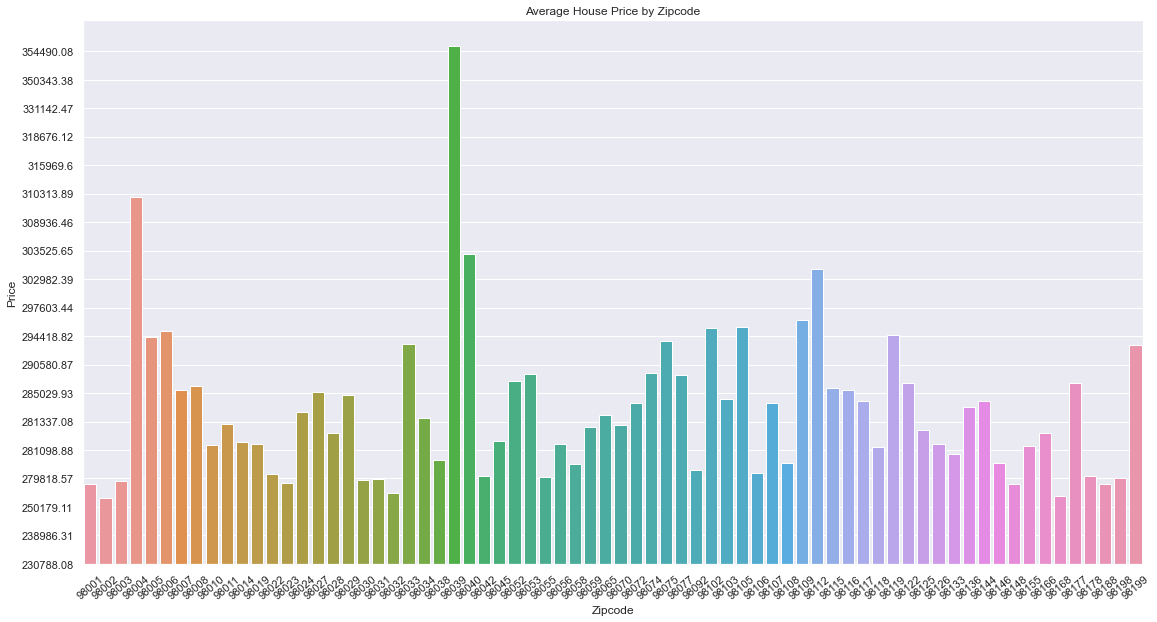

In [107]:
price_by_zipcode=pd.DataFrame([])
price_by_zipcode['zipcode']=pd.concat([kc_new2.groupby(['zipcode'])['price'].mean()]).index
price_by_zipcode=price_by_zipcode.set_index('zipcode')
price_by_zipcode['price']=pd.concat([kc_new2.groupby(['zipcode'])['price'].mean()]).values
price_by_zipcode.head(10)
# kc_new.groupby(['zipcode'])['price'].mean().index
# price_by_zipcode.rename({'':'price'},axis=1)
plot=plt.figure(figsize=(19,10))
# price_by_zipcode=price_by_zipcode.sort_values()
zip_price=sns.barplot(x=price_by_zipcode.index,y=price_by_zipcode['price'])
zip_price.set_xticklabels(labels=price_by_zipcode.index, rotation=40)
zip_price.set_yticklabels(labels=round(price_by_zipcode['price'].sort_values(),2))
zip_price.set_yticks(price_by_zipcode['price'])
plt.yticks(np.arange(0,price_by_zipcode['price'].max(), 100000))#,price_by_zipcode['price'].max())
# plt.locator_params(axis='x',nbins=10)
# plt.locator_params(axis='y',nbins=10)
zip_price.set(title='Average House Price by Zipcode',xlabel='Zipcode',ylabel='Price')

### OLS Model

In [137]:
outcome = 'price'
predictors = kc_fin2.drop(['price','zipcode'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
print(formula)

price~bedrooms+bathrooms+sqft_living+sqft_lot+cnd_2+cnd_3+cnd_4+cnd_5


In [138]:
model = ols(formula=formula, data=kc_fin2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     2253.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:50:33   Log-Likelihood:                -9178.8
No. Observations:               21061   AIC:                         1.838e+04
Df Residuals:                   21052   BIC:                         1.845e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      13.2128      0.073    181.587      0.000      13.070      13.355
cnd_2[T.1]     -0.0868      0.076     -1.136      0.256      -0.237       0.063
cnd_3[T.1]      0.0444      0.071      0.626      0.531      -0.095       0.183
cnd_4[T.1]      0.1066      0.071      1.501      0.133      -0.033       0.246
cnd_5[T.1]      0.2132      0.071      2.984      0.003       0.073       0.353
bedrooms       -0.0968      0.004    -23.666      0.000      -0.105      -0.089
bathrooms       0.0391      0.006      6.785      0.000       0.028       0.050
sqft_living     0.3929      0.005     81.695      0.000       0.384       0.402
sqft_lot       -0.0485      0.003    -16.956      0.000      -0.054      -0.043
==============================================================================
Omnibus:                       68.943   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.132
Skew:                           0.127   Prob(JB):                     1.60e-15
Kurtosis:                       2.887   Cond. No.                         259.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
outcome = 'price'
predictors = kc_unlog.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

price~bedrooms+bathrooms+living+lot+zip_98002+zip_98003+zip_98004+zip_98005+zip_98006+zip_98007+zip_98008+zip_98010+zip_98011+zip_98014+zip_98019+zip_98022+zip_98023+zip_98024+zip_98027+zip_98028+zip_98029+zip_98030+zip_98031+zip_98032+zip_98033+zip_98034+zip_98038+zip_98039+zip_98040+zip_98042+zip_98045+zip_98052+zip_98053+zip_98055+zip_98056+zip_98058+zip_98059+zip_98065+zip_98070+zip_98072+zip_98074+zip_98075+zip_98077+zip_98092+zip_98102+zip_98103+zip_98105+zip_98106+zip_98107+zip_98108+zip_98109+zip_98112+zip_98115+zip_98116+zip_98117+zip_98118+zip_98119+zip_98122+zip_98125+zip_98126+zip_98133+zip_98136+zip_98144+zip_98146+zip_98148+zip_98155+zip_98166+zip_98168+zip_98177+zip_98178+zip_98188+zip_98198+zip_98199+cnd_2+cnd_3+cnd_4+cnd_5


In [114]:
model2 = ols(formula=formula, data=kc_unlog).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     784.3
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:42:14   Log-Likelihood:            -2.8263e+05
No. Observations:               21061   AIC:                         5.654e+05
Df Residuals:                   20983   BIC:                         5.660e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.264e+05   3.23e+04     -3.907      0.000    -1.9e+05    -6.3e+04
zip_98002[T.1]  1.777e+04   1.46e+04      1.214      0.225   -1.09e+04    4.65e+04
zip_98003[T.1]  9839.6284   1.31e+04      0.752      0.452   -1.58e+04    3.55e+04
zip_98004[T.1]  7.994e+05   1.29e+04     62.030      0.000    7.74e+05    8.25e+05
zip_98005[T.1]  3.503e+05   1.56e+04     22.516      0.000     3.2e+05    3.81e+05
zip_98006[T.1]  3.315e+05   1.16e+04     28.691      0.000    3.09e+05    3.54e+05
zip_98007[T.1]  2.753e+05   1.66e+04     16.560      0.000    2.43e+05    3.08e+05
zip_98008[T.1]  3.034e+05   1.31e+04     23.147      0.000    2.78e+05    3.29e+05
zip_98010[T.1]  6.663e+04   1.86e+04      3.590      0.000    3.02e+04    1.03e+05
zip_98011[T.1]    1.3e+05   1.46e+04      8.910      0.000    1.01e+05    1.59e+05
zip_98014[T.1]   7.98e+04   1.73e+04      4.611      0.000    4.59e+04    1.14e+05
zip_98019[T.1]  7.244e+04   1.47e+04      4.923      0.000    4.36e+04    1.01e+05
zip_98022[T.1]  1.697e+04   1.39e+04      1.222      0.222   -1.03e+04    4.42e+04
zip_98023[T.1] -1.278e+04   1.13e+04     -1.130      0.258   -3.49e+04    9381.115
zip_98024[T.1]  1.551e+05   2.09e+04      7.434      0.000    1.14e+05    1.96e+05
zip_98027[T.1]  1.768e+05   1.19e+04     14.859      0.000    1.54e+05       2e+05
zip_98028[T.1]  1.317e+05    1.3e+04     10.108      0.000    1.06e+05    1.57e+05
zip_98029[T.1]   2.37e+05   1.27e+04     18.714      0.000    2.12e+05    2.62e+05
zip_98030[T.1]  8896.8736   1.34e+04      0.663      0.507   -1.74e+04    3.52e+04
zip_98031[T.1]  1.599e+04   1.31e+04      1.217      0.224   -9769.885    4.18e+04
zip_98032[T.1]  1.031e+04   1.71e+04      0.604      0.546   -2.31e+04    4.37e+04
zip_98033[T.1]  3.896e+05   1.18e+04     33.115      0.000    3.67e+05    4.13e+05
zip_98034[T.1]  2.222e+05   1.11e+04     19.956      0.000       2e+05    2.44e+05
zip_98038[T.1]  2.245e+04   1.09e+04      2.050      0.040     988.275    4.39e+04
zip_98039[T.1]  1.213e+06   2.73e+04     44.442      0.000    1.16e+06    1.27e+06
zip_98040[T.1]  5.743e+05   1.35e+04     42.472      0.000    5.48e+05    6.01e+05
zip_98042[T.1]  5958.0862   1.11e+04      0.537      0.591   -1.58e+04    2.77e+04
zip_98045[T.1]  1.048e+05    1.4e+04      7.461      0.000    7.73e+04    1.32e+05
zip_98052[T.1]  2.594e+05    1.1e+04     23.491      0.000    2.38e+05    2.81e+05
zip_98053[T.1]  2.124e+05    1.2e+04     17.733      0.000    1.89e+05    2.36e+05
zip_98055[T.1]  4.904e+04   1.32e+04      3.704      0.000    2.31e+04     7.5e+04
zip_98056[T.1]  1.053e+05   1.19e+04      8.874      0.000    8.21e+04    1.29e+05
zip_98058[T.1]  3.711e+04   1.15e+04      3.214      0.001    1.45e+04    5.97e+04
zip_98059[T.1]  9.726e+04   1.15e+04      8.436      0.000    7.47e+04     1.2e+05
zip_98065[T.

### Multicollinearity Check

The model has some multicollinearity. First between the categorical variables and another between the number of bathrooms and the sqft_living, but that is to be expected. In this model, because the number of bathrooms as well as the sqft_living space is both important in determining the appropriate housing for the clients, neither variables will not be taken out.

In [15]:
abs(predictors.corr()) >.75

,bedrooms,bathrooms,sqft_living,sqft_lot
bedrooms,True,False,False,False
bathrooms,False,True,False,False
sqft_living,False,False,True,False
sqft_lot,False,False,False,True


In [16]:
kc_pred=kc_fin2.drop(['price'],axis=1)
pred_df=kc_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
pred_df['pairs'] = list(zip(pred_df.level_0, pred_df.level_1))

# set index to pairs
pred_df.set_index(['pairs'], inplace = True)

#d rop level columns
pred_df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
pred_df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
pred_df.drop_duplicates(inplace=True)

In [17]:
pred_df[(pred_df.cc>.75) & (pred_df.cc <1)]

,cc
pairs,


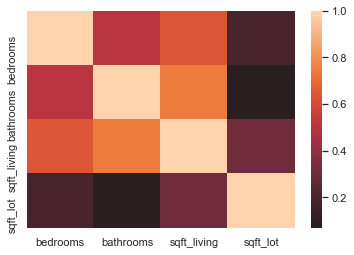

In [18]:
sns.heatmap(predictors.corr(), center=0);

## Model Training

Creating test and train sets using 2:8 ratio. 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(predictors,kc_fin2['price'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16848, 9), (4213, 9), (16848,), (4213,))

In [20]:
lr=LinearRegression()#positive=True)
predictors=sm.add_constant(predictors)
# y_train=np.array(y_train).reshape(-1,1)
lr.fit(X_train,y_train)
# predict_ls=fit_lr.predict(predictors)

yhat_train=lr.predict(X_train)
yhat_test=lr.predict(X_test)

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values e

In [21]:
np.array(X_train).shape#.reshape(-1,1).shape

(16848, 9)

In [22]:
train_residuals = yhat_train - y_train
test_residuals = yhat_test - y_test

In [23]:
mse_train = np.sum((y_train-yhat_train)**2)/len(y_train)
mse_test = np.sum((y_test-yhat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.13724843286280866
Test Mean Squarred Error: 0.13841279996855135


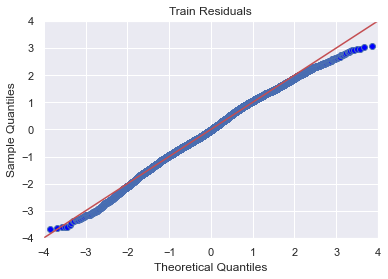

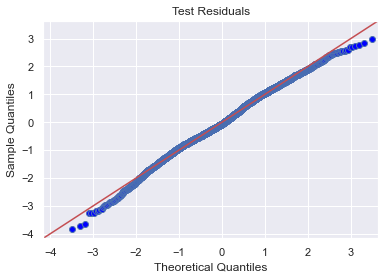

In [24]:
sm.graphics.qqplot(train_residuals,dist=stats.norm,line='45',fit=True)
plt.title('Train Residuals')
sm.graphics.qqplot(test_residuals,dist=stats.norm,line='45',fit=True)
plt.title('Test Residuals')
plt.show()

### Regression Model

The model with the actual data shows that number of bedrooms and size of lot decreases the price of the house while the number of bathrooms and size of living space increases the price.

In [25]:
lr.fit(X=predictors,y=kc_fin2['price'])
print(predictors.columns)
lr.coef_

Index(['const', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'zipcode',
       'cnd_2', 'cnd_3', 'cnd_4', 'cnd_5'],
      dtype='object')


F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


array([ 0.        , -0.09375567,  0.05514649,  0.39053107, -0.03420704,
        0.00100456, -0.08964545,  0.05186613,  0.12066058,  0.21211262])

In [110]:
lr.fit(X=kc_unlog.drop(['price'],axis=1),y=kc_unlog['price'])
print(kc_unlog.drop(['price'],axis=1).columns)
lr.coef_

Index(['bedrooms', 'bathrooms', 'living', 'lot', 'zip_98002', 'zip_98003',
       'zip_98004', 'zip_98005', 'zip_98006', 'zip_98007', 'zip_98008',
       'zip_98010', 'zip_98011', 'zip_98014', 'zip_98019', 'zip_98022',
       'zip_98023', 'zip_98024', 'zip_98027', 'zip_98028', 'zip_98029',
       'zip_98030', 'zip_98031', 'zip_98032', 'zip_98033', 'zip_98034',
       'zip_98038', 'zip_98039', 'zip_98040', 'zip_98042', 'zip_98045',
       'zip_98052', 'zip_98053', 'zip_98055', 'zip_98056', 'zip_98058',
       'zip_98059', 'zip_98065', 'zip_98070', 'zip_98072', 'zip_98074',
       'zip_98075', 'zip_98077', 'zip_98092', 'zip_98102', 'zip_98103',
       'zip_98105', 'zip_98106', 'zip_98107', 'zip_98108', 'zip_98109',
       'zip_98112', 'zip_98115', 'zip_98116', 'zip_98117', 'zip_98118',
       'zip_98119', 'zip_98122', 'zip_98125', 'zip_98126', 'zip_98133',
       'zip_98136', 'zip_98144', 'zip_98146', 'zip_98148', 'zip_98155',
       'zip_98166', 'zip_98168', 'zip_98177', 'zip_98178', 'z

array([-3.90266043e+04,  9.94687716e+03,  2.45670803e+02,  3.22862083e-01,
        1.77693267e+04,  9.83962839e+03,  7.99369615e+05,  3.50266126e+05,
        3.31510130e+05,  2.75282552e+05,  3.03364692e+05,  6.66292570e+04,
        1.30036979e+05,  7.97961191e+04,  7.24383281e+04,  1.69705382e+04,
       -1.27820599e+04,  1.55080496e+05,  1.76825835e+05,  1.31730703e+05,
        2.37002078e+05,  8.89687360e+03,  1.59940287e+04,  1.03096564e+04,
        3.89564948e+05,  2.22166458e+05,  2.24476149e+04,  1.21263088e+06,
        5.74288346e+05,  5.95808621e+03,  1.04791671e+05,  2.59376787e+05,
        2.12403778e+05,  4.90352480e+04,  1.05342343e+05,  3.71096792e+04,
        9.72616374e+04,  9.11290817e+04,  1.54913209e+05,  1.70420280e+05,
        2.25548523e+05,  2.48377065e+05,  1.63690997e+05, -1.87433918e+04,
        5.13800367e+05,  3.50385880e+05,  5.05410806e+05,  1.37495533e+05,
        3.56556557e+05,  1.17897600e+05,  5.40708192e+05,  6.36534611e+05,
        3.48009122e+05,  

# Linear Regression Assumptions

Proving that the assumptions regarding regression is met using the linear regression model above

## Linearity
The scatter plot of the independent variables to the dependent variables show that they have a linear relationship. The scatter plots also show that the data is homoscedastic, meeting two of the three assumptions.

<ipython-input-155-e9201948cb2f>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_beds.set_yticklabels(data['price'])


[Text(0.5, 0, 'Number of Bedrooms'),
 Text(0, 0.5, 'Price'),
 Text(0.5, 1.0, 'Relationship between Price and the Number of Bedrooms')]

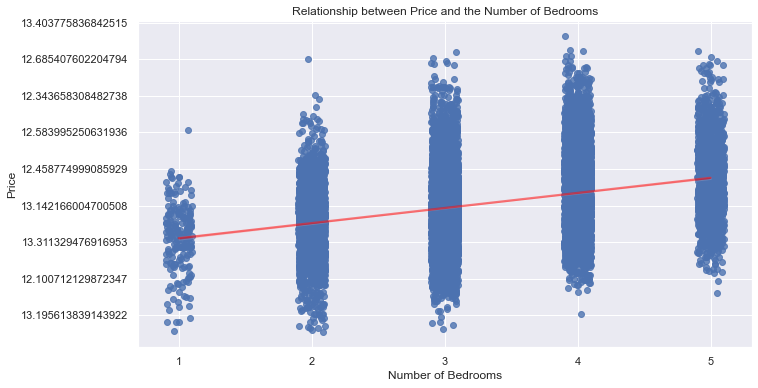

In [155]:
data=kc_fin2
price_unlog=round(np.exp(data['price']),2)
plot=plt.figure(figsize=(11,6))
ax_beds=sns.regplot(x='bedrooms',y='price',data=data,x_jitter=.1, line_kws={'color':'red','alpha':.5})
ax_beds.set_yticklabels(data['price'])
ax_beds.set(xlabel='Number of Bedrooms',ylabel='Price',title='Relationship between Price and the Number of Bedrooms')

<ipython-input-154-89b9a090d37b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_baths.set_yticklabels(data['price'])


[Text(0.5, 0, 'Number of Bathrooms'),
 Text(0, 0.5, 'Price'),
 Text(0.5, 1.0, 'Relationship between Price and the Number of Bathrooms')]

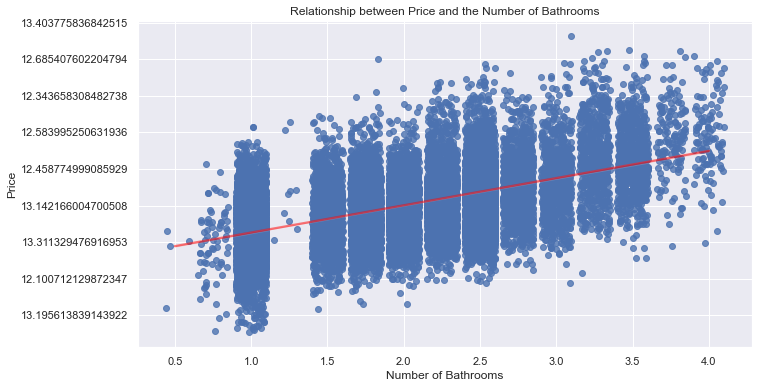

In [154]:
plot=plt.figure(figsize=(11,6))

ax_baths=sns.regplot(x='bathrooms',y='price',data=data,x_jitter=.1, line_kws={'color':'red','alpha':.5})
ax_baths.set_yticklabels(data['price'])
ax_baths.set(xlabel='Number of Bathrooms',ylabel='Price',title='Relationship between Price and the Number of Bathrooms')

[Text(0.5, 0, 'Size of Living Space in Sq. ft.'),
 Text(0, 0.5, 'Price'),
 Text(0.5, 1.0, 'Relationship between Price and the Sq. ft of Living Space')]

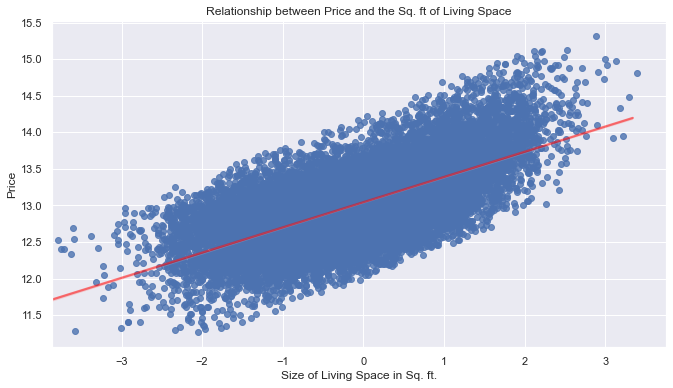

In [127]:
living_unlog=round(np.exp(logsqft_living),3)
data2=kc_fin2
plot=plt.figure(figsize=(11,6))
ax_living=sns.regplot(x='sqft_living',y='price',data=data2,x_jitter=.1, line_kws={'color':'red','alpha':.5})
# ax_living.set_yticklabels(price_unlog)
# ax_living.set_xticklabels('sqft_living')
ax_living.set(xlabel='Size of Living Space in Sq. ft.',ylabel='Price',title='Relationship between Price and the Sq. ft of Living Space')

While we may assume heteroscedasticity for the sqft_lot, this is because there are many apartments meaning many of these houses have 0 sqft_lot. The price difference between apartments varies significantly depending on location, sqft of living space, commodities, and etc. If we overlook the top and bottom part of the scatter plot where sqft_lot is near 0, the rest of the plot is very linear.

<ipython-input-156-2dd6b37ff589>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_lot.set_yticklabels(data['price'])


[Text(0.5, 0, 'Size of Lot Space'),
 Text(0, 0.5, 'Price'),
 Text(0.5, 1.0, 'Relationship between Price and the Sq. ft of Lot Space')]

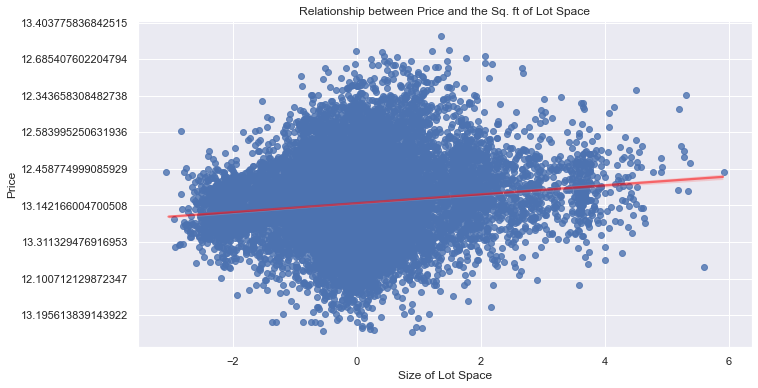

In [156]:
plot=plt.figure(figsize=(11,6))
data2=kc_fin2
ax_lot=sns.regplot(x='sqft_lot',y='price',data=data2,x_jitter=.1, line_kws={'color':'red','alpha':.5})
ax_lot.set_yticklabels(data['price'])
# ax_lot.set_xticklabels('sqft_lot')
ax_lot.set(xlabel='Size of Lot Space',ylabel='Price',title='Relationship between Price and the Sq. ft of Lot Space')

<br><br>

Without log transforming and normalizing the values, the graphs look like this, however, these graphs do show a relationship between the said independent variable and price with real world values. 

<ipython-input-26-2efe6f26d105>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_beds.set_yticklabels(price_unlog)


[Text(0.5, 0, 'Number of Bedrooms'),
 Text(0, 0.5, 'Price'),
 Text(0.5, 1.0, 'Relationship between Price and the Number of Bedrooms')]

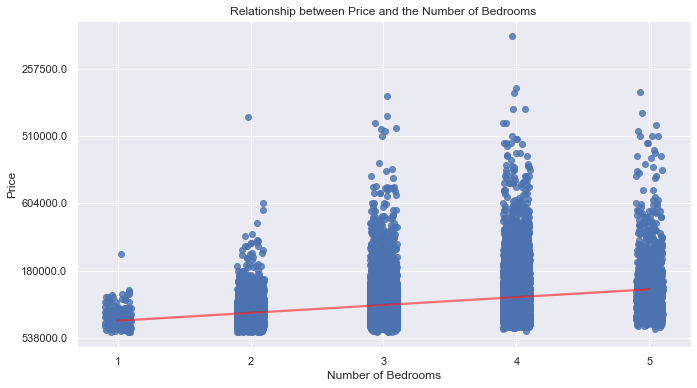

In [26]:
data=kc_fin2
price_unlog=round(np.exp(data['price']),2)
plot=plt.figure(figsize=(11,6))
ax_beds=sns.regplot(x='bedrooms',y=price_unlog,data=data,x_jitter=.1, line_kws={'color':'red','alpha':.5})
ax_beds.set_yticklabels(price_unlog)
ax_beds.set(xlabel='Number of Bedrooms',ylabel='Price',title='Relationship between Price and the Number of Bedrooms')

<ipython-input-27-2f9281687dbc>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_baths.set_yticklabels(price_unlog)


[Text(0.5, 0, 'Number of Bathrooms'),
 Text(0, 0.5, 'Price'),
 Text(0.5, 1.0, 'Relationship between Price and the Number of Bathrooms')]

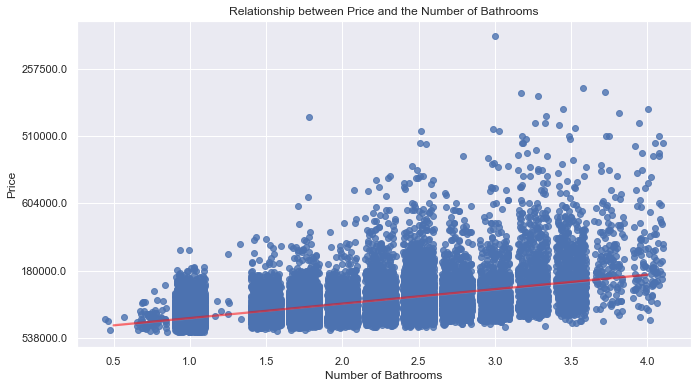

In [27]:
plot=plt.figure(figsize=(11,6))

ax_baths=sns.regplot(x='bathrooms',y=price_unlog,data=data,x_jitter=.1, line_kws={'color':'red','alpha':.5})
ax_baths.set_yticklabels(price_unlog)
ax_baths.set(xlabel='Number of Bathrooms',ylabel='Price',title='Relationship between Price and the Number of Bathrooms')

<ipython-input-115-87e78f0cf0b1>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_living.set_yticklabels(price_unlog)
<ipython-input-115-87e78f0cf0b1>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_living.set_xticklabels(data2['living'].sort_values())


[Text(0.5, 0, 'Size of Living Space in Sq. ft.'),
 Text(0, 0.5, 'Price'),
 Text(0.5, 1.0, 'Relationship between Price and the Sq. ft of Living Space')]

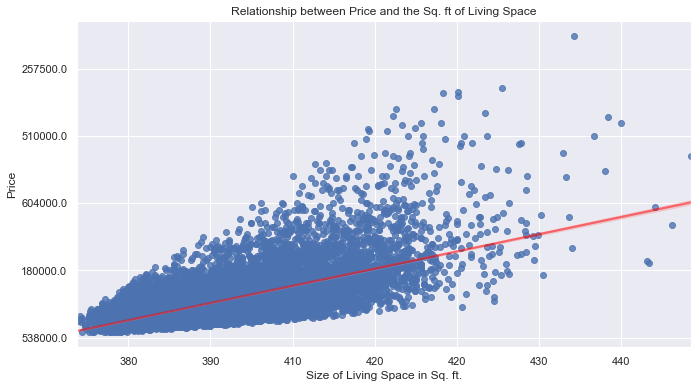

In [115]:
living_unlog=round(np.exp(logsqft_living),3)
data2=kc_unlog
plot=plt.figure(figsize=(11,6))
ax_living=sns.regplot(x=data2['living'],y=price_unlog,data=data2,x_jitter=.1, line_kws={'color':'red','alpha':.5})
ax_living.set_yticklabels(price_unlog)
ax_living.set_xticklabels(data2['living'].sort_values())
ax_living.set(xlabel='Size of Living Space in Sq. ft.',ylabel='Price',title='Relationship between Price and the Sq. ft of Living Space')

<ipython-input-116-206411a9fec9>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_lot.set_yticklabels(price_unlog)
<ipython-input-116-206411a9fec9>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_lot.set_xticklabels(data2['lot'].sort_values())


[Text(0.5, 0, 'Size of Lot Space'),
 Text(0, 0.5, 'Price'),
 Text(0.5, 1.0, 'Relationship between Price and the Sq. ft of Lot Space')]

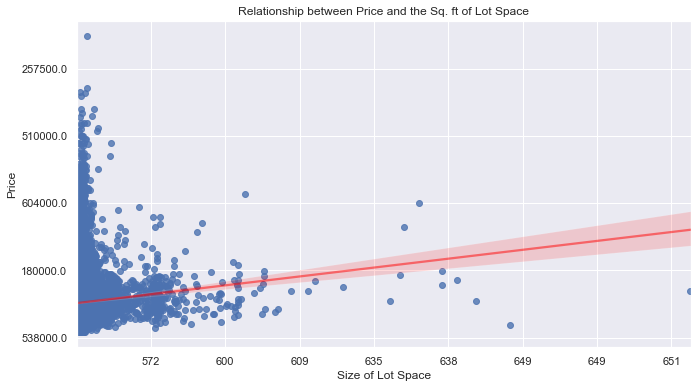

In [116]:
plot=plt.figure(figsize=(11,6))
data2=kc_unlog
ax_lot=sns.regplot(x=data2['lot'],y=price_unlog,data=data2,x_jitter=.1, line_kws={'color':'red','alpha':.5})
ax_lot.set_yticklabels(price_unlog)
ax_lot.set_xticklabels(data2['lot'].sort_values())
ax_lot.set(xlabel='Size of Lot Space',ylabel='Price',title='Relationship between Price and the Sq. ft of Lot Space')

## Normality

### Q-Q Plot of the residuals

First by building a residuals data frame, I was able to create a Q-Q plot of the residuals using model.resid. The Q-Q plot shows that while it is not perfectly normally distributed, it is quite close.

In [145]:
residual_df=pd.DataFrame(sorted(model.resid), columns=['residual'])

In [146]:
residual_df['z_actual']=(residual_df['residual'].map 
                         (lambda x: (x-residual_df['residual'].mean())/residual_df['residual'].std()))
residual_df['rank']=residual_df.index+1
residual_df['percentile']=residual_df['rank'].map(lambda x: x/len(residual_df.residual))
residual_df['theo']=stats.norm.ppf(residual_df['percentile'])
residual_df['error']=residual_df['z_actual']-residual_df['theo']

residual_df.head()

,residual,z_actual,rank,percentile,theo,error
0,-1.171094,-3.129997,1,0.000047,-3.903116,0.773119
1,-1.120389,-2.994477,2,0.000095,-3.732054,0.737577
2,-1.109063,-2.964205,3,0.000142,-3.628669,0.664463
3,-1.106855,-2.958305,4,0.000190,-3.553702,0.595397
4,-1.097792,-2.934082,5,0.000237,-3.494578,0.560496


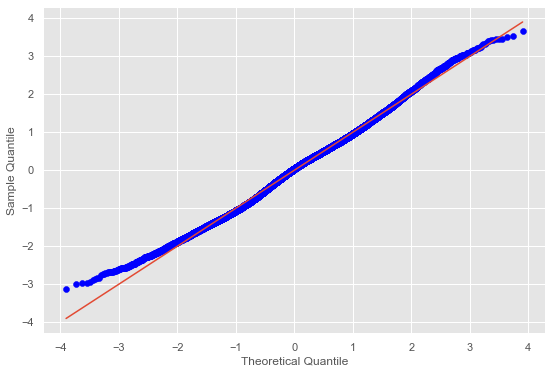

In [147]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(9,6))
    plt.scatter(residual_df['theo'],residual_df['z_actual'],color='blue')
    plt.xlabel('Theoretical Quantile')
    plt.ylabel('Sample Quantile')
    plt.plot(residual_df['theo'],residual_df['theo'])

### Histogram of Residuals 

Like the Q-Q plots, the histogram of the residuals also shows that the data is nearly normally distributed. 


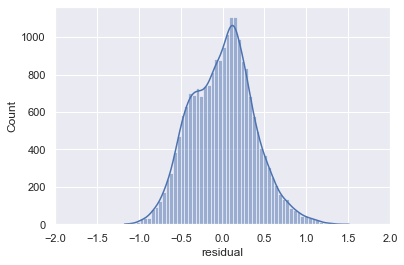

In [148]:
sns.histplot(residual_df['residual'],bins=60, kde=True, cbar=True)
plt.xlim((-2,2))
plt.show()

### Visualizing Error Terms

This section has a better visual representation of the linearity and homoscedasticity of the data. 

 - The Y and Fitted vs. X graph plots the dependent variable against our predicted values with a confidence interval. The positive relationship shows that independent varible and price are correlated, i.e., when one variable increases the other increases.

 - The Residuals versus height graph shows our model's errors versus the specified predictor variable. Each dot is an observed value; the line represents the mean of those observed values. If there's no pattern in the distance between the dots and the mean value, the OLS assumption of homoskedasticity holds.

 - The Partial regression plot shows the relationship between the independent variable and price, taking in to account the impact of adding other independent variables on our existing  coefficient. 

 - The Component and Component Plus Residual (CCPR) plot is an extension of the partial regression plot. It shows where the trend line would lie after adding the impact of adding our other independent variables on the price.

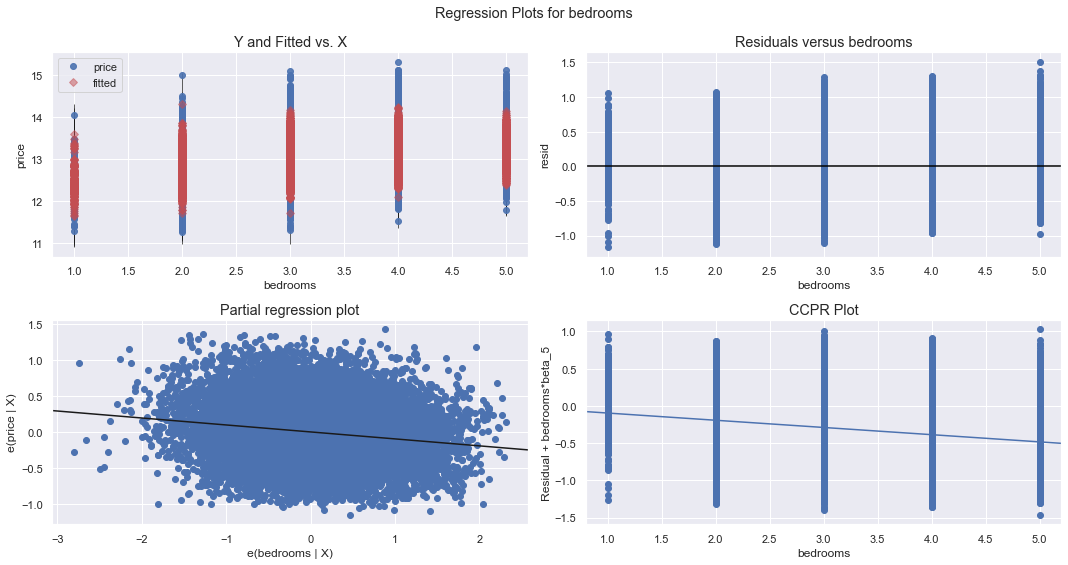

In [149]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bedrooms", fig=fig)
plt.show()

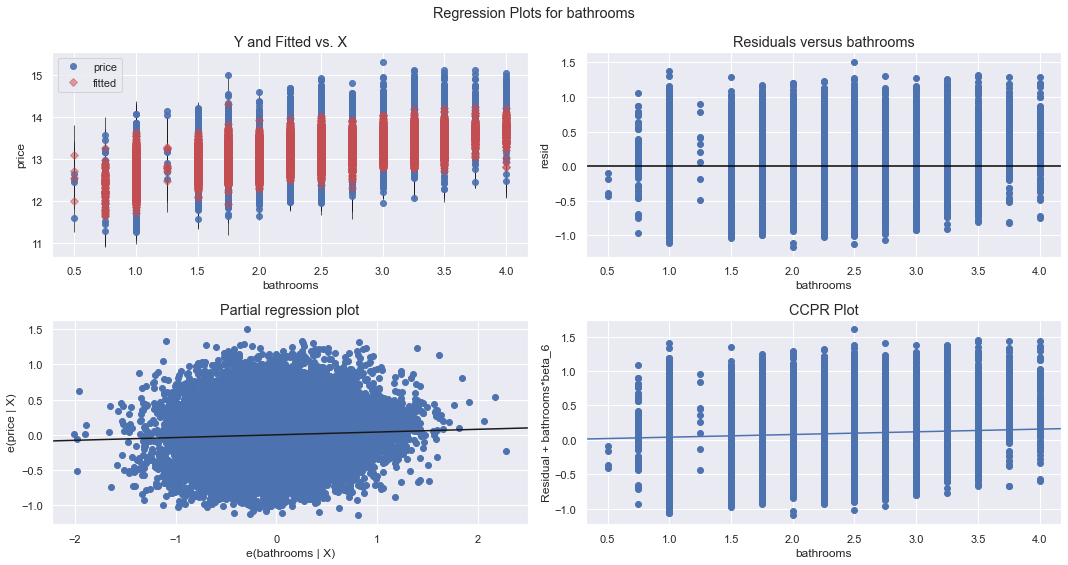

In [150]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bathrooms", fig=fig)
plt.show()

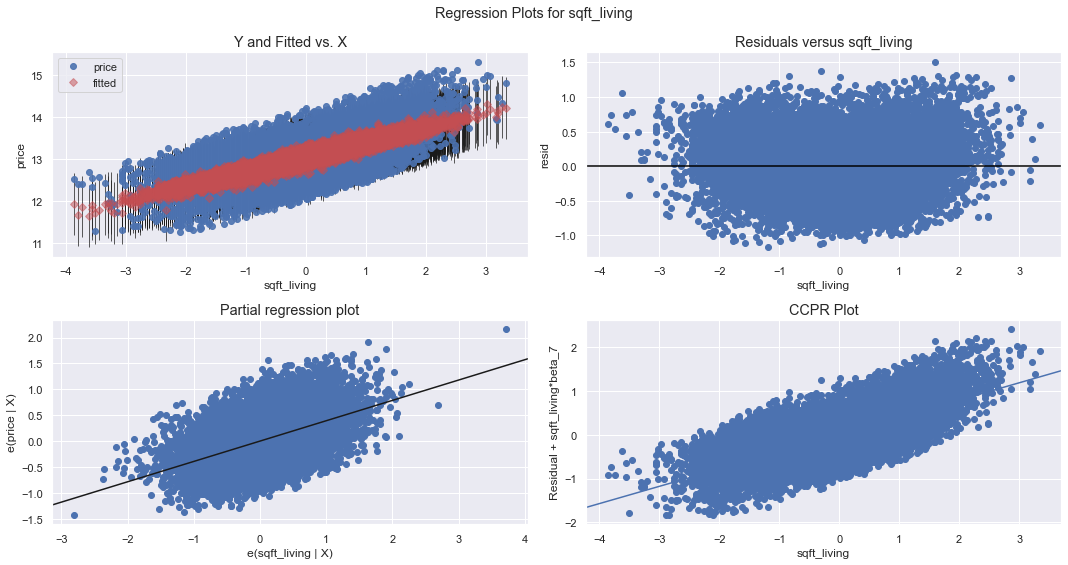

In [151]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

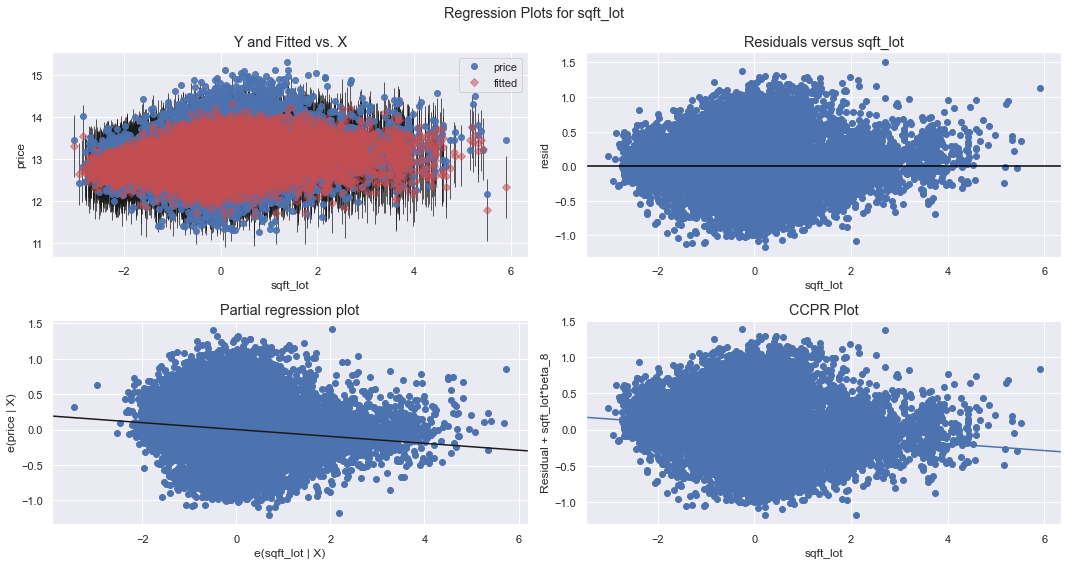

In [152]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_lot", fig=fig)
plt.show()

# Evaluation

By taking bedrooms, bathrooms, size of living space and lot, and the zipcodes, I believe I was able to portray housing prices in King County well. While zipcode had been ignored at start, the price differences between houses of similar specs could not be explained very well, but with the introduction of zip codes, I realized that much of the price difference had been caused by location. 

 - Because the variable zip codes was categorical, it could not be graphed like condition; however, after observing the mean housing price by zip codes, it was very apparant that zip code played a much bigger role in price determination. <br><br>
 
 - Because apartments/condos account for higher prices for houses with a lot size of 0(or other very small number), and thus explains the negative relationship between price and lot size.<br><br>
 

# Conclusion

The biggest challenges were first, trying to figure out why the relationship between lot size and number of bedrooms to the price were negative, and much effort was put into trying to make the coefficients be positive in the model. Realizing that area played an important role in determining housing price was very important as it allowed me to view zip codes as a necessary independent variable. While not having much information regarding the actual geographical location of each area as well as other amenities of each zip code may hinder in providing the best recommendation, knowing that each zip code has different price ranges will help narrowing down potential housing for the clients. 
<br>

 - Organize and categorize different zip codes with housing price range and amenities such as public education, transportation, and other facilities in order to facilitate faster and more suitable recommendations.<br><br>
 - Start oragnizing advertisements targeted to those that are looking to move to the King County area to gain possible clients. <br><br>
 - In the future, having a better understanding of the local traffic, local shopping/food/activities areas, and other factors that clients are looking for in their new neighborhood, would be able to create more fitted lists for the clients. 